# On va faire une evaluation de nos modeles

In [56]:
# importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

from sklearn import metrics

# Charger les donnes

In [28]:
data = pd.read_csv('Outputs/data.csv')

In [8]:
data.shape

(9322, 19)

# Nouvelle Approche
L'idee est d'essayer de labeleliser nos donnees, c'est a dire detecter les outliers et les inliers en faisant des predictions basiques avec nos 4 modeles. L'idee est qu'ensuite on puisse avoir une idee assez claire des anomalies pour pouvoir par la suite essayer de confirmer ou non les performances d'un modele par rapport a l'autre

In [29]:
# On va recuperer les colonnes numeriques et categoricielles des donnees

# On recupere les colonnes numeriques
numerical_features = data.select_dtypes(exclude=['object']).columns

# On recupere les colonnes categoricielles
categorical_features = data.select_dtypes(include=['object']).columns

In [15]:
def encode_categorical_features(data):
    for feature in categorical_features:
        data[feature] = LabelEncoder().fit_transform(data[feature])
    return data

# On va creer une foncion global qui nous permettra de creer un pipeline avec des caracteristiques differentes

# Créer une fonction de transformation pour les variables catégorielles
cat_transformer = FunctionTransformer(encode_categorical_features)

# Creer un preprocessor
def create_preprocessor(transform_for_num = None):
    numerical_pipeline = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        transform_for_num
    )

    # On ne fera plus de transformations sur les variables categoricielles

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, data.select_dtypes(exclude=['object']).columns),
        ('cat', cat_transformer, data.select_dtypes(include=['object']).columns)
        ]
    )
    return preprocessor

def create_pipeline(model = None, transform_for_num = None):

    preprocessor = create_preprocessor(transform_for_num)
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )
    return pipeline

# On va commencer par le Isolation Forest

In [21]:
# On va creer un pipeline avec le model Isolation Forest
pipeline = create_pipeline(model = IsolationForest(), transform_for_num = RobustScaler())

# On va entrainer le model
pipeline.fit(data)

# On va recuperer les predictions
iForest_predictions = pipeline.predict(data)

iForest_scores = pipeline.decision_function(data)

print(iForest_scores)
print(iForest_predictions)

[0.0963078  0.10000135 0.04584412 ... 0.11908549 0.10768081 0.08026013]
[1 1 1 ... 1 1 1]


In [22]:
# Afficher le nombre de fraudes et de non fraudes dans les predictions

print('Fraudulent transactions: {}'.format(iForest_predictions[iForest_predictions == -1].shape[0]))
print('Normal transactions: {}'.format(iForest_predictions[iForest_predictions == 1].shape[0]))

Fraudulent transactions: 1340
Normal transactions: 7982


Conclusion :
Le model a detecte 1340 anomalies sur 10000 transactions

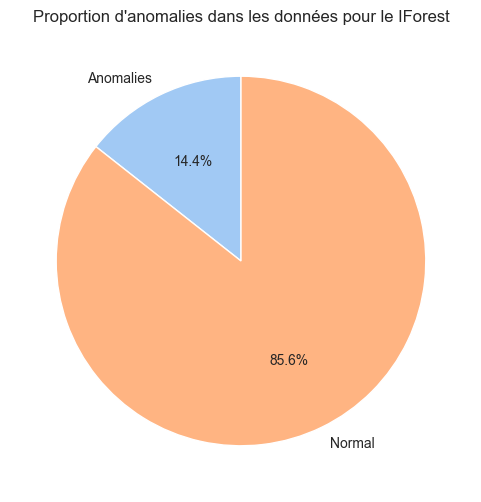

In [23]:
# Faire un affichage graphique circulaire pour voir les anomalies avec seaborn

# On va créer un dictionnaire des anomalies
anomalies = {'Anomalies': sum(iForest_predictions == -1), 'Normal': sum(iForest_predictions == 1)}

# On va créer un graphique circulaire
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_palette('pastel')
sns.color_palette()
sns.set_style('white')
ax.pie(anomalies.values(), labels=anomalies.keys(), autopct='%1.1f%%', startangle=90)

# On va ajouter un titre au graphique
ax.set_title('Proportion d\'anomalies dans les données pour le IForest')

# On va afficher le graphique
plt.show()

# On va maintenant essayer le OC-SVM

In [29]:
# On va creer un pipeline avec le model OC-SVM
pipeline = create_pipeline(model = OneClassSVM(kernel='linear', gamma='auto', nu=0.9), transform_for_num = MinMaxScaler())

# On va entrainer le model
pipeline.fit(data)

# On va recuperer les predictions
ocSVM_predictions = pipeline.predict(data)

ocSVM_scores = pipeline.decision_function(data)

print(ocSVM_scores)
print(ocSVM_predictions)

[-4.66979418e+10  2.87964686e+10  9.51141995e+09 ...  8.45712968e+09
 -4.91681459e+10 -2.93978098e+10]
[-1  1  1 ...  1 -1 -1]


In [31]:
# Afficher le nombre de fraudes et de non fraudes dans les predictions

print('Fraudulent transactions: {}'.format(ocSVM_predictions[ocSVM_predictions == 1].shape[0]))
print('Normal transactions: {}'.format(ocSVM_predictions[ocSVM_predictions == -1].shape[0]))

Fraudulent transactions: 932
Normal transactions: 8390


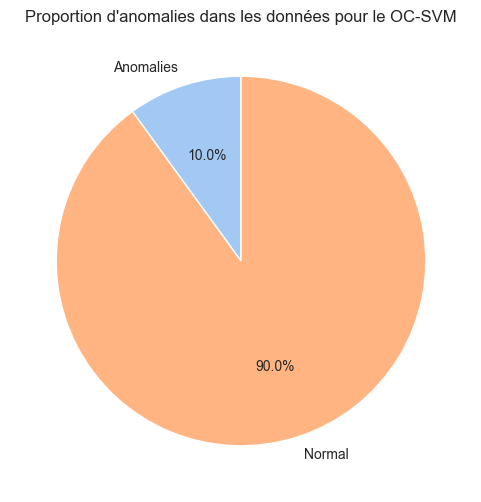

In [39]:
# Faire un affichage graphique circulaire pour voir les anomalies avec seaborn

# On va créer un dictionnaire des anomalies
anomalies = {'Anomalies': sum(ocSVM_predictions == 1), 'Normal': sum(ocSVM_predictions == -1)}

# On va créer un graphique circulaire
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_palette('pastel')
sns.color_palette()
sns.set_style('white')
ax.pie(anomalies.values(), labels=anomalies.keys(), autopct='%1.1f%%', startangle=90)

# On va ajouter un titre au graphique
ax.set_title('Proportion d\'anomalies dans les données pour le OC-SVM')

# On va afficher le graphique
plt.show()

# On va maintenant essayer le Local Outlier Factor

In [36]:
# On va creer un pipeline avec le model Local Outlier Factor
pipeline = create_pipeline(model = LocalOutlierFactor(n_neighbors=20, contamination=0.1), transform_for_num = MinMaxScaler())

# On va entrainer le model
lof_predictions = pipeline.fit_predict(data)

lof_scores = pipeline.named_steps['model'].negative_outlier_factor_

print(lof_scores)
print(lof_predictions)

[-1.02367966 -1.30336056 -0.98447616 ... -1.04402682 -0.99487818
 -1.11469871]
[ 1 -1  1 ...  1  1 -1]


In [37]:
# Afficher le nombre de fraudes et de non fraudes dans les predictions

print('Fraudulent transactions: {}'.format(lof_predictions[lof_predictions == -1].shape[0]))
print('Normal transactions: {}'.format(lof_predictions[lof_predictions == 1].shape[0]))

Fraudulent transactions: 933
Normal transactions: 8389


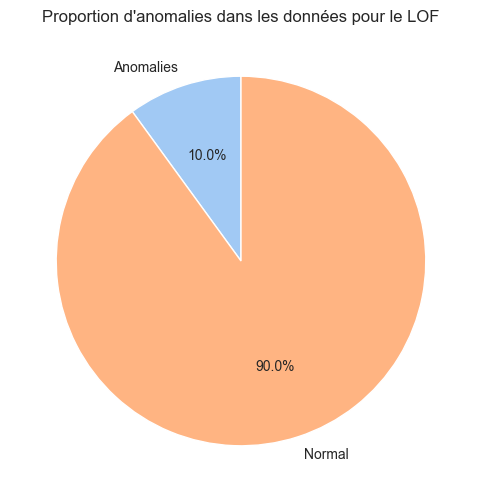

In [40]:
# Faire un affichage graphique circulaire pour voir les anomalies avec seaborn

# On va créer un dictionnaire des anomalies
anomalies = {'Anomalies': sum(lof_predictions == -1), 'Normal': sum(lof_predictions == 1)}

# On va créer un graphique circulaire
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_palette('pastel')
sns.color_palette()
sns.set_style('white')
ax.pie(anomalies.values(), labels=anomalies.keys(), autopct='%1.1f%%', startangle=90)

# On va ajouter un titre au graphique
ax.set_title('Proportion d\'anomalies dans les données pour le LOF')

# On va afficher le graphique
plt.show()

# On va maintenant essayer le K-Means

In [82]:
from sklearn.cluster import KMeans

# On va creer un pipeline avec le model K-Means
pipeline = create_pipeline(model = KMeans(n_clusters=2, init='k-means++', max_iter=800, algorithm='lloyd', tol=2.0), transform_for_num = MinMaxScaler())

# On va entrainer le model
pipeline.fit(data)

# On va recuperer les predictions
kmeans_predictions = pipeline.predict(data)

print(kmeans_predictions)

[0 0 0 ... 0 1 1]


D:\Documents\Stage PFE\Projet\Codes\BenchmarkCodes\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [83]:
# Afficher le nombre de fraudes et de non fraudes dans les predictions

print('Fraudulent transactions: {}'.format(kmeans_predictions[kmeans_predictions == 1].shape[0]))
print('Normal transactions: {}'.format(kmeans_predictions[kmeans_predictions == 0].shape[0]))

Fraudulent transactions: 4613
Normal transactions: 4709


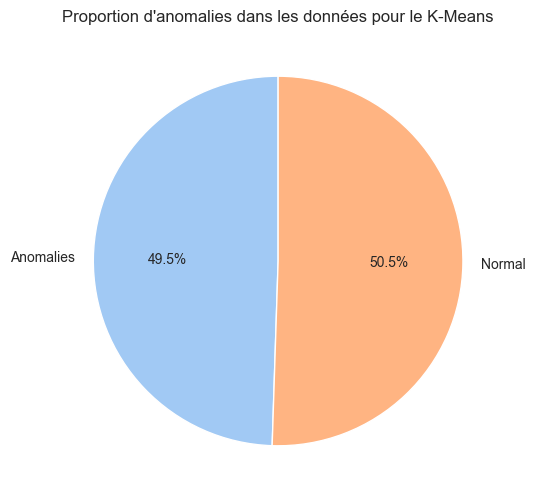

In [84]:
# Faire un affichage graphique circulaire pour voir les anomalies avec seaborn

# On va créer un dictionnaire des anomalies
anomalies = {'Anomalies': sum(kmeans_predictions == 1), 'Normal': sum(kmeans_predictions == 0)}

# On va créer un graphique circulaire
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_palette('pastel')
sns.color_palette()
sns.set_style('white')
ax.pie(anomalies.values(), labels=anomalies.keys(), autopct='%1.1f%%', startangle=90)

# On va ajouter un titre au graphique
ax.set_title('Proportion d\'anomalies dans les données pour le K-Means')

# On va afficher le graphique
plt.show()

# Le K-Means n'est pas tres performant sur nos donnees car il detecte autant d'anomalies que de donnees normales, ce qui n'est pas tres realiste. On va donc s'en passer pour la suite

In [86]:
# On va remplacer les valeurs -1 par 1 et 1 par 0 dans Iforest_predictions et lof_predictions

iForest_predictions[iForest_predictions == -1] = -1000
iForest_predictions[iForest_predictions == 1] = 0
iForest_predictions[iForest_predictions == -1000] = 1

lof_predictions[lof_predictions == -1] = -1000
lof_predictions[lof_predictions == 1] = 0
lof_predictions[lof_predictions == -1000] = 1

# On fait l'inverse dans ocSVM_predictions, c'est a dire -1 devient 0 tout simplement

ocSVM_predictions[ocSVM_predictions == -1] = 0

In [87]:
# On va creer des colonnes dans data pour stocker les predictions et scores de chaque model

data['iForest_predictions'] = iForest_predictions
data['iForest_scores'] = iForest_scores

data['ocSVM_predictions'] = ocSVM_predictions
data['ocSVM_scores'] = ocSVM_scores

data['lof_predictions'] = lof_predictions
data['lof_scores'] = lof_scores

In [88]:
# On va maintenat creer une colonne qui va stocker la prediction finale de notre model en fonction des predictions de chaque model, cette colonne sera 1 quand toutes les autres predictions sont a 1 au meme moment et 0 sinon

data['final_prediction'] = data['iForest_predictions'] & data['ocSVM_predictions'] & data['lof_predictions']

In [96]:
# On va creer une colonne similaire mais juste pour le Iforest et le lof

data['final_prediction_IForest_LOF'] = data['iForest_predictions'] & data['lof_predictions']

In [99]:
# On va creer une colonne similaire mais juste pour le Iforest et le ocSVM

data['final_prediction_IForest_ocSVM'] = data['iForest_predictions'] & data['ocSVM_predictions']

In [101]:
# On va creer une colonne similaire mais juste pour le ocSVM et le lof

data['final_prediction_ocSVM_LOF'] = data['ocSVM_predictions'] & data['lof_predictions']

In [103]:
# On va maintenant creer une colonne final_prediction_2 qui va combiner les 3 predictions precedente

data['final_prediction_2'] = data['final_prediction_IForest_LOF'] | data['final_prediction_IForest_ocSVM'] | data['final_prediction_ocSVM_LOF']

In [104]:
print(len(data.loc[data['final_prediction'] == 1]))
print(len(data.loc[data['final_prediction_IForest_LOF'] == 1]))
print(len(data.loc[data['final_prediction_IForest_ocSVM'] == 1]))
print(len(data.loc[data['final_prediction_ocSVM_LOF'] == 1]))
print(len(data.loc[data['final_prediction_2'] == 1]))

16
118
130
121
337


# Conclusion
On a que 16 anomalies qui sont confirmes simultanement par nos 3 modeles
On a cependant environ 120 qui sont confirme simultanement par 2 modeles a chaque fois
Et pour finir 337 predictions qui sont confirmees par au moins une combinaison des 2 modeles

In [95]:
data.loc[data['final_prediction'] == 1]

,numero_compte,lib_etendu,bilan,montant_signe,signe,diff_ope_val,diff_ope_val_signe,transactions_counts,iForest_predictions,iForest_scores,ocSVM_predictions,ocSVM_scores,lof_predictions,lof_scores,final_prediction
853,f37d59400317539047bb895fb0e1d050,d9459b18bc3face35c971eb53a4f3ed0,72800,41.24,+,1.0,+,5.0,1,-0.059124,1,1.736767e+10,1,-1.106342,1
2179,eae65f1b5a4b08c295258a74389f1ced,c032d56dd6bd7fb41c9a2ad2767cdd6b,21110,160000.00,+,-1.0,-,15.0,1,-0.107296,1,3.875905e+09,1,-1.115890,1
3061,c507b3ee99facefc0aaa42e5b40fe9ab,fbd0ad03ec2e7f7e82ecd29d4249fe9b,47110,3000.00,+,32150.0,+,2.0,1,-0.104395,1,1.346709e+10,1,-1.207199,1
4541,e8c01302cb4cbe960a1c5c329b6467d8,f218cbd62f0a35e98d4434f46f84455b,21110,315000.00,+,0.0,+,2.0,1,-0.067882,1,2.275670e+10,1,-1.184443,1
4760,fd6de2f8953c6dae16213b34bfdeb996,ee47fcf05ea9e47d431351837470fb01,74912,25.00,+,0.0,+,1.0,1,-0.062281,1,2.981837e+10,1,-1.244303,1
5237,fee72a475137c89a1d859f656d5d1334,cf005b44e0522a9b6d36188f010c1535,11110,-1200000.00,-,1.0,+,4.0,1,-0.120075,1,1.775443e+10,1,-1.182095,1
5238,fee72a475137c89a1d859f656d5d1334,fc717e4475d6f82852ff3fb7d1100670,11110,-258600.00,-,1.0,+,5.0,1,-0.080617,1,3.604780e+10,1,-1.167521,1
6165,f18145cd0ce034bfe3cf08ddcfef1102,fc388e81b081a0e685f90471965bedbd,21210,-993723.47,-,-1.0,-,8.0,1,-0.157092,1,3.062998e+10,1,-1.677838,1
6169,f18145cd0ce034bfe3cf08ddcfef1102,bfb87e8bca81b4a8e8ef087da4d8242e,21210,43300.00,+,-1.0,-,12.0,1,-0.085458,1,6.386524e+09,1,-1.116851,1
6223,ee2ef65efe514e52ed612117497c419d,fee9f2c57ce3b7509b74a1797574cc9b,21210,-600000.00,-,1.0,+,3.0,1,-0.082032,1,3.025330e+10,1,-1.265980,1


In [3]:
data.loc[data['final_prediction_2'] == 1]

,numero_compte,lib_etendu,bilan,montant_signe,signe,diff_ope_val,diff_ope_val_signe,transactions_counts,iForest_predictions,iForest_scores,ocSVM_predictions,ocSVM_scores,lof_predictions,lof_scores,final_prediction,final_prediction_IForest_LOF,final_prediction_IForest_ocSVM,final_prediction_ocSVM_LOF,final_prediction_2
1,ebd12c14b29d5e3c9c0785ea41787292,fdbb71769ecf00d5778f657271bc9d9b,21110,-200.00,-,1.0,+,2.0,0,0.100001,1,2.879647e+10,1,-1.303361,0,0,0,1,1
69,e4d57b6b6ba23fa9acdb105376da01ff,fdbb71769ecf00d5778f657271bc9d9b,21110,-200.00,-,1.0,+,1.0,0,0.102843,1,2.605016e+10,1,-1.087900,0,0,0,1,1
74,f513f9c213693d3eea1d3970f768246f,dbc60e2bcdd1844eeb436eb0ad92abaf,21110,250.00,+,-1.0,-,2.0,0,0.033630,1,1.918848e+10,1,-1.116343,0,0,0,1,1
213,fe4ceced0755d5cf57ac3bf90d9c2139,b45f740639531fa7b36585c70dccc1d4,21110,-15057.00,-,1.0,+,2.0,0,0.088848,1,7.488513e+09,1,-1.227747,0,0,0,1,1
323,c9aee73a03c6f2a7b88b1f92c6832493,fdbb71769ecf00d5778f657271bc9d9b,21110,-200.00,-,1.0,+,3.0,0,0.099958,1,1.586094e+10,1,-1.145376,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,fb7e40a8cf576cf3eb4afcd640d82ee9,f105a102ea0e4226066731dba1b7ddc1,21110,-2800.00,-,4.0,+,1.0,0,0.068577,1,3.037823e+10,1,-1.362072,0,0,0,1,1
8983,fbb4aa583954d34741f540eb09d20d45,f63c78b6318dce39f42161d6c56df3e5,21110,-3838.88,-,1.0,+,2.0,0,0.092824,1,3.241770e+10,1,-1.086254,0,0,0,1,1
9019,c3ae28d36b7d4fb8916525af5724548d,fdbb71769ecf00d5778f657271bc9d9b,21110,-200.00,-,1.0,+,1.0,0,0.112844,1,1.359225e+10,1,-1.154619,0,0,0,1,1
9162,fe7768f8ecebfac8b0e2e4f66df2d95b,b0638b4cb9749f16c6d59f2d9cd183d7,21110,-2000.00,-,4.0,+,1.0,0,0.079681,1,5.960949e+09,1,-1.186892,0,0,0,1,1


In [30]:
data = pd.read_csv('Outputs/data_with_predictions.csv')

# On va essayer de faire une analyse des resultats pour mieux comprendre les anomalies

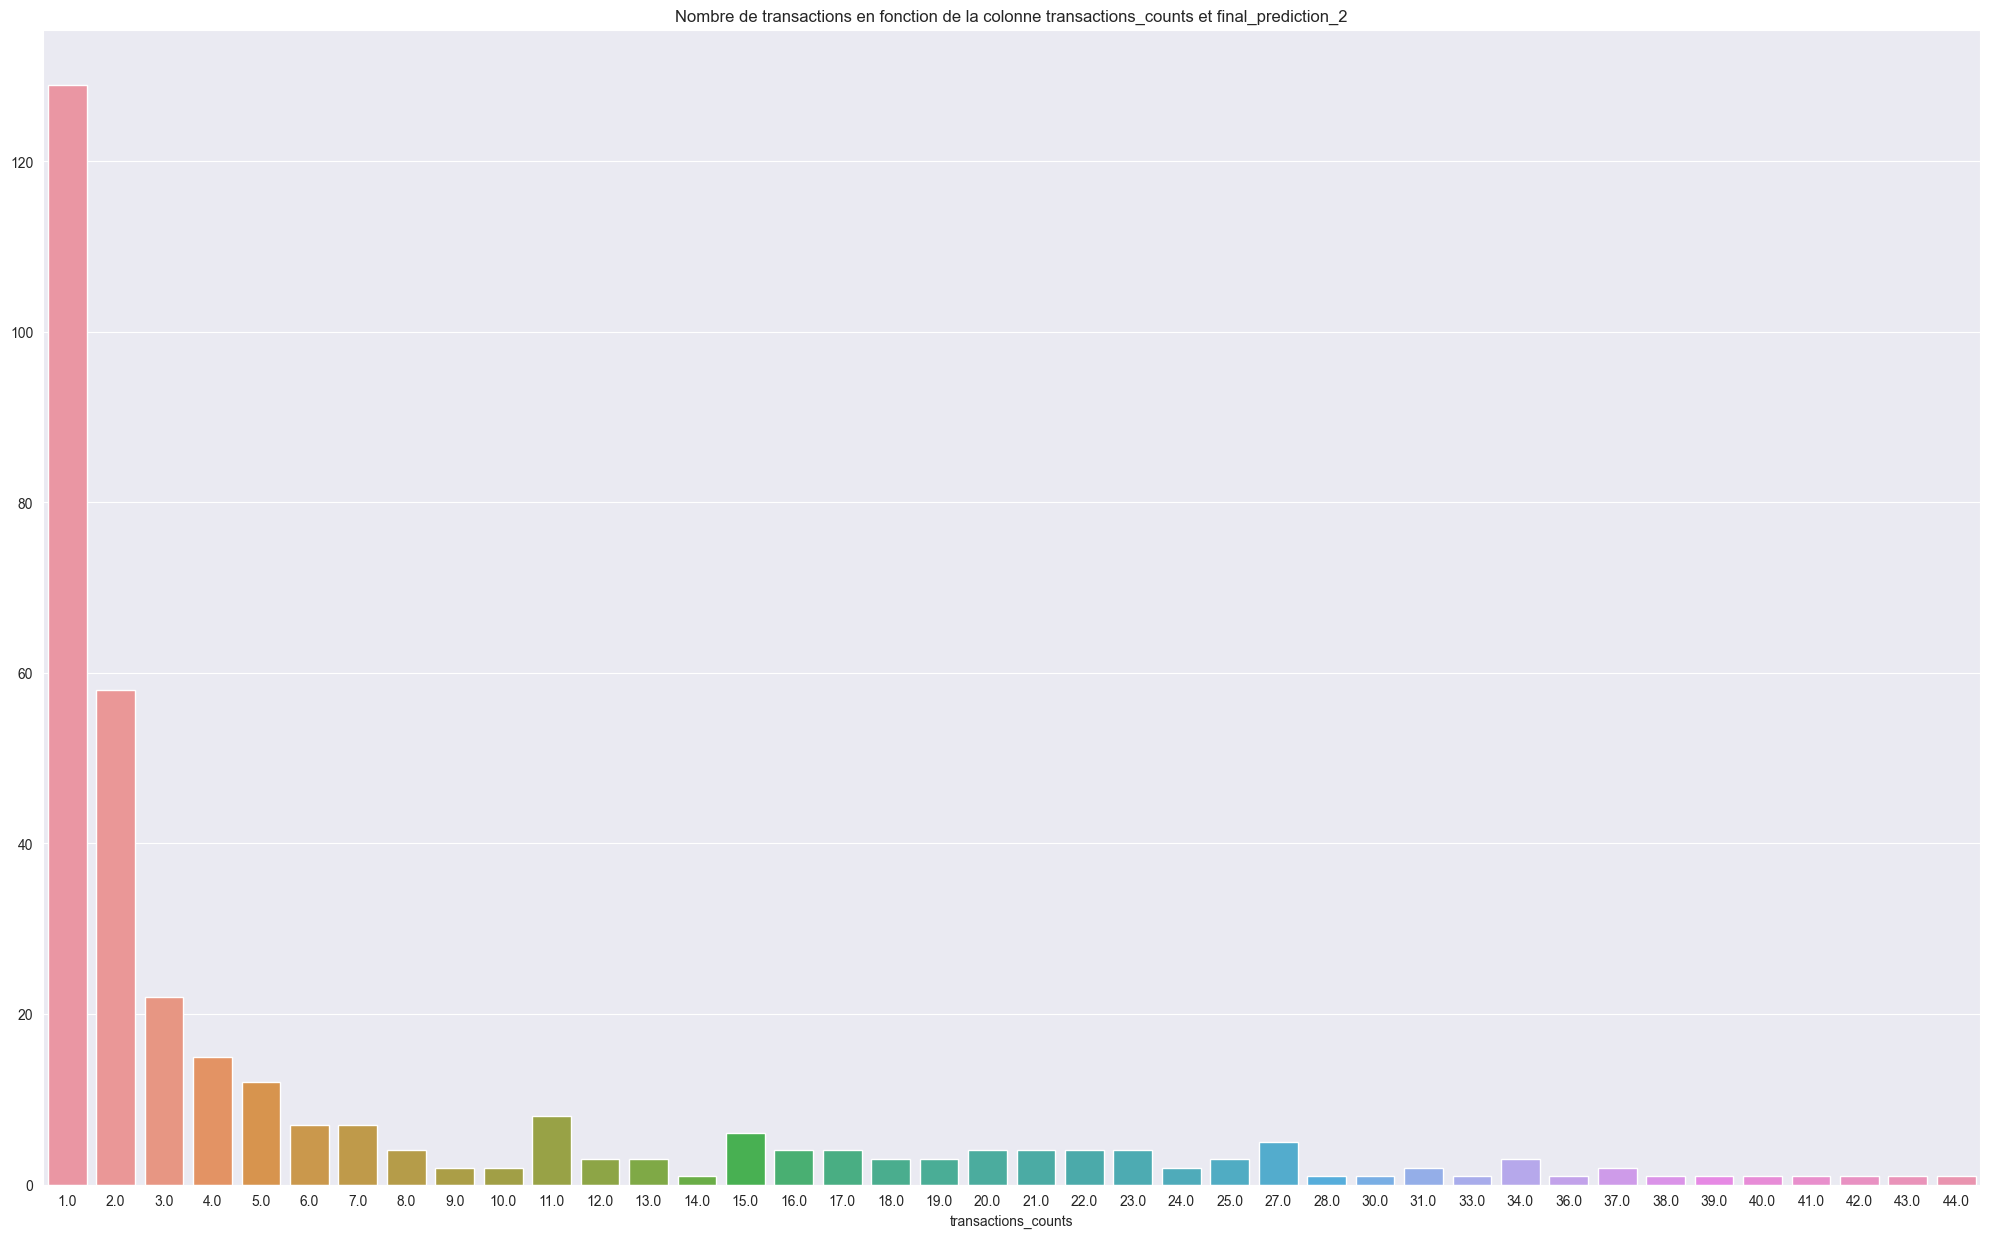

In [6]:
plt.figure(figsize=(25, 15))
sns.barplot(x=data.loc[data['final_prediction_2'] == 1, 'transactions_counts'].value_counts().index, y=data.loc[data['final_prediction_2'] == 1, 'transactions_counts'].value_counts().values)
plt.title('Nombre de transactions en fonction de la colonne transactions_counts et final_prediction_2')
plt.show()

# Conclusion
Environ 130 transactions frauduleuses sur 337 (38.57%) ont eu lieu lors de la 1ere transaction. Pour le reste, elles ont eu lieu a la nieme transaction avec n > 2. On remarque cependant que plus les transactions se multiplient, et moins on aurait de risque de fraudes

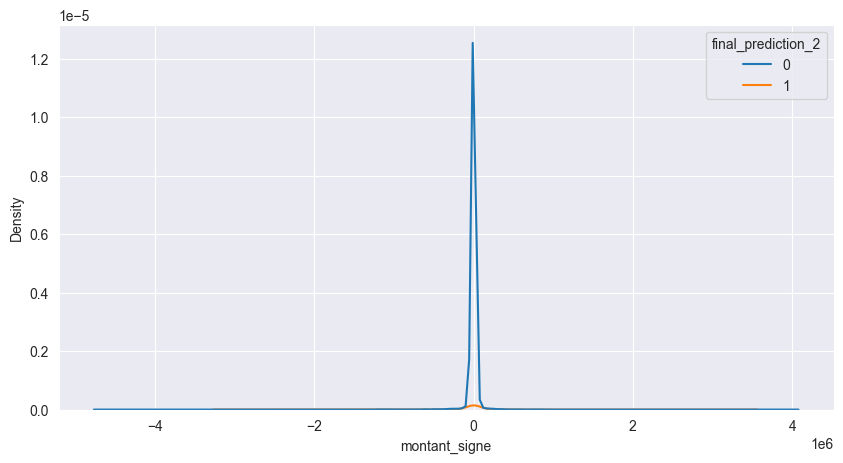

In [23]:
# Voyons la distributtion des fraudes en fonction des montants

plt.figure(figsize=(10, 5))
sns.kdeplot(data = data, x='montant_signe', hue='final_prediction_2')
plt.show()

# Conclusion
La plupart des transactions frauduleuses se concentrent pour des montants faibles, ce qui est justifie par le fait que la majortite des transactions sont dans cet intervalle egalement

In [24]:
# On va maintenant voir quel modele a le mieux fonctionne pour la detection. Pour cela on va voir le pourcentage de fraudes qui se retrouve a la fois dans les predictions du modele et dans les vraies fraudes

print('Pourcentage de fraudes detectees par le IForest : ', len(data.loc[(data['iForest_predictions'] == 1) & (data['final_prediction_2'] == 1)]) * 100 / len(data.loc[data['final_prediction_2'] == 1]))

print('Pourcentage de fraudes detectees par le ocSVM : ', len(data.loc[(data['ocSVM_predictions'] == 1) & (data['final_prediction_2'] == 1)]) * 100 / len(data.loc[data['final_prediction_2'] == 1]))

print('Pourcentage de fraudes detectees par le LOF : ', len(data.loc[(data['lof_predictions'] == 1) & (data['final_prediction_2'] == 1)]) * 100 / len(data.loc[data['final_prediction_2'] == 1]))

Pourcentage de fraudes detectees par le IForest :  68.8427299703264
Pourcentage de fraudes detectees par le ocSVM :  69.73293768545994
Pourcentage de fraudes detectees par le LOF :  66.17210682492582


# On va maintenant creer des experiences avec MLflow afin de determiner le meilleur model

In [33]:
data = pd.read_csv('Outputs/data_with_predictions.csv')

In [34]:
data.head()

,numero_compte,lib_etendu,bilan,montant_signe,signe,diff_ope_val,diff_ope_val_signe,transactions_counts,iForest_predictions,iForest_scores,ocSVM_predictions,ocSVM_scores,lof_predictions,lof_scores,final_prediction,final_prediction_IForest_LOF,final_prediction_IForest_ocSVM,final_prediction_ocSVM_LOF,final_prediction_2
0,ebd12c14b29d5e3c9c0785ea41787292,41ce64b36b9cfe92670dcdfa7ad4ca9b,21110,-99.0,-,4.0,+,1.0,0,0.096308,0,-4.669794e+10,0,-1.023680,0,0,0,0,0
1,ebd12c14b29d5e3c9c0785ea41787292,fdbb71769ecf00d5778f657271bc9d9b,21110,-200.0,-,1.0,+,2.0,0,0.100001,1,2.879647e+10,1,-1.303361,0,0,0,1,1
2,ebd12c14b29d5e3c9c0785ea41787292,ce2bf864bfcd82b4bf01120c79d7ba46,21110,1900.0,+,-1.0,-,3.0,0,0.045844,1,9.511420e+09,0,-0.984476,0,0,0,0,0
3,b9a371e2aa5b4a9a9801b639896db549,1fd98623f4623649bac0dd8c65ec49ce,21110,-1000.0,-,4.0,+,1.0,0,0.096639,0,-7.900028e+10,0,-1.014100,0,0,0,0,0
4,a45c978dca989f17c7c8bb2cada9514f,234f3006bad9b99df4e4d08556484dc9,21110,-2700.0,-,4.0,+,1.0,0,0.092883,0,-8.570494e+10,0,-0.987901,0,0,0,0,0


In [35]:
data = data.drop(['numero_compte', 'iForest_predictions', 'ocSVM_predictions', 'lof_predictions', 'final_prediction', 'final_prediction_IForest_LOF', 'final_prediction_IForest_ocSVM', 'final_prediction_ocSVM_LOF', 'iForest_scores', 'ocSVM_scores', 'lof_scores'], axis=1)
data_copy = data.copy()
data = data.drop(['final_prediction_2'], axis=1)

In [36]:
data_copy.head()

,lib_etendu,bilan,montant_signe,signe,diff_ope_val,diff_ope_val_signe,transactions_counts,final_prediction_2
0,41ce64b36b9cfe92670dcdfa7ad4ca9b,21110,-99.0,-,4.0,+,1.0,0
1,fdbb71769ecf00d5778f657271bc9d9b,21110,-200.0,-,1.0,+,2.0,1
2,ce2bf864bfcd82b4bf01120c79d7ba46,21110,1900.0,+,-1.0,-,3.0,0
3,1fd98623f4623649bac0dd8c65ec49ce,21110,-1000.0,-,4.0,+,1.0,0
4,234f3006bad9b99df4e4d08556484dc9,21110,-2700.0,-,4.0,+,1.0,0


Pour les metriques, on va utiliser la precision, le recall et le f1 score et l'aire sous la courbe ROC

On commence avec le IForest

In [39]:
mlflow.sklearn.autolog()

In [47]:
# On va definir l'experience du Isolation Forest

mlflow.set_experiment("Iforest_experiment_2")

<Experiment: artifact_location='file:///D:/Documents/Stage%20PFE/Projet/Codes/BenchmarkCodes/mlruns/652241067840679150', creation_time=1682353521750, experiment_id='652241067840679150', last_update_time=1682353521750, lifecycle_stage='active', name='Iforest_experiment_2', tags={}>

In [48]:
n_estimators = [200, 300, 400, 500, 1000]
max_samples = ['auto', 0.1, 0.01, 0.05, 0.001]
contaminations = ['auto', 0.1, 0.01, 0.05]

for n_estimator in n_estimators:
    for max_sample in max_samples:
        for contamination in contaminations:
            with mlflow.start_run(run_name=f"IsolationForest_with_{n_estimator}_n_estimator_{max_sample}_max_sample_{contamination}_contamination") as run:
                # On va creer un pipeline avec le model Isolation Forest
                pipeline = create_pipeline(model = IsolationForest(n_estimators=n_estimator, max_samples=max_sample, contamination=contamination), transform_for_num = RobustScaler())

                # On va entrainer le model
                pipeline.fit(data)

                # On va recuperer les predictions
                predictions = pipeline.predict(data)

                predictions[predictions == -1] = -1000
                predictions[predictions == 1] = 0
                predictions[predictions == -1000] = 1

                # On va ajouter les metrics
                mlflow.log_metric('precision', metrics.precision_score(data_copy['final_prediction_2'], predictions))
                mlflow.log_metric('recall', metrics.recall_score(data_copy['final_prediction_2'], predictions))
                mlflow.log_metric('f1_score', metrics.f1_score(data_copy['final_prediction_2'], predictions))
                mlflow.log_metric('roc_auc_score', metrics.roc_auc_score(data_copy['final_prediction_2'], predictions))


            mlflow.end_run()

2023/04/24 18:05:13 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 Index(['bilan', 'montant_signe', 'diff_ope_val', 'transactions_counts'], dtype='object')),
                     ...`
2023/04/24 18:05:13 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('robustscaler',
                          

On peut maintenant faire la meme chose pour le lof

In [49]:
mlflow.set_experiment("LOF_experiment_2")

<Experiment: artifact_location='file:///D:/Documents/Stage%20PFE/Projet/Codes/BenchmarkCodes/mlruns/423577100941850152', creation_time=1682355669262, experiment_id='423577100941850152', last_update_time=1682355669262, lifecycle_stage='active', name='LOF_experiment_2', tags={}>

In [50]:
n_neighbors = [20, 25, 30, 35, 40]
algorithms = ['kd_tree', 'brute', 'auto', 'ball_tree']
leaf_sizes = [20, 30, 40, 50]
contaminations = ['auto', 0.05, 0.1, 0.001]

for n_neighbor in n_neighbors:
    for algorithm in algorithms:
        for leaf_size in leaf_sizes:
            for contamination in contaminations:
                with mlflow.start_run(run_name=f"LOF_with_{n_neighbor}_n_neighbor_{algorithm}_algorithm_{leaf_size}_leaf_size_{contamination}_contamination") as run:
                    # On va creer un pipeline avec le model LOF
                    pipeline = create_pipeline(model = LocalOutlierFactor(n_neighbors=n_neighbor, algorithm=algorithm, leaf_size=leaf_size, contamination=contamination), transform_for_num = MinMaxScaler())
                    '''
                    # On va entrainer le model
                    pipeline.fit(data)
                    '''
                    # On va recuperer les predictions
                    predictions = pipeline.fit_predict(data)

                    predictions[predictions == -1] = -1000
                    predictions[predictions == 1] = 0
                    predictions[predictions == -1000] = 1

                    # On va ajouter les metrics
                    mlflow.log_metric('precision', metrics.precision_score(data_copy['final_prediction_2'], predictions))
                    mlflow.log_metric('recall', metrics.recall_score(data_copy['final_prediction_2'], predictions))
                    mlflow.log_metric('f1_score', metrics.f1_score(data_copy['final_prediction_2'], predictions))
                    mlflow.log_metric('roc_auc_score', metrics.roc_auc_score(data_copy['final_prediction_2'], predictions))

                mlflow.end_run()

2023/04/24 18:19:23 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['bilan', 'montant_signe', 'diff_ope_val', 'transactions_counts'], dtype='object')),
                     ...`
2023/04/24 18:19:23 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                          

On termine par le ocSVM

In [51]:
mlflow.set_experiment("ocSVM_experiment_2")

2023/04/24 18:42:56 INFO mlflow.tracking.fluent: Experiment with name 'ocSVM_experiment_2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/Documents/Stage%20PFE/Projet/Codes/BenchmarkCodes/mlruns/734717506817775942', creation_time=1682358176605, experiment_id='734717506817775942', last_update_time=1682358176605, lifecycle_stage='active', name='ocSVM_experiment_2', tags={}>

In [52]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gammas = ['scale', 'auto']
nus = [0.1, 0.3, 0.5, 0.7, 0.9]

for n in nus:
    for k in kernels:
        for g in gammas:
            for contamination in contaminations:
                with mlflow.start_run(run_name=f"ocSVM_with_{n}_nu_{k}_kernel_{g}_gamma_{contamination}_contamination") as run:
                    # On va creer un pipeline avec le model ocSVM
                    pipeline = create_pipeline(model = OneClassSVM(nu=n, kernel=k, gamma=g), transform_for_num = MinMaxScaler())

                    # On va entrainer le model
                    pipeline.fit(data)

                    # On va recuperer les predictions
                    predictions = pipeline.predict(data)

                    predictions[predictions == -1] = 0

                    # On va ajouter les metrics
                    mlflow.log_metric('precision', metrics.precision_score(data_copy['final_prediction_2'], predictions))
                    mlflow.log_metric('recall', metrics.recall_score(data_copy['final_prediction_2'], predictions))
                    mlflow.log_metric('f1_score', metrics.f1_score(data_copy['final_prediction_2'], predictions))
                    mlflow.log_metric('roc_auc_score', metrics.roc_auc_score(data_copy['final_prediction_2'], predictions))

                mlflow.end_run()

2023/04/24 18:42:56 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['bilan', 'montant_signe', 'diff_ope_val', 'transactions_counts'], dtype='object')),
                     ...`
2023/04/24 18:42:56 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                          

On va essayer avec la K-Means a 2 clusters

In [54]:
# On va definir l'experience du K-Means

mlflow.set_experiment("K-Means_experiment_2")

2023/04/24 21:16:21 INFO mlflow.tracking.fluent: Experiment with name 'K-Means_experiment_2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/Documents/Stage%20PFE/Projet/Codes/BenchmarkCodes/mlruns/394057446346780171', creation_time=1682367381550, experiment_id='394057446346780171', last_update_time=1682367381550, lifecycle_stage='active', name='K-Means_experiment_2', tags={}>

In [57]:
inits = ['k-means++', 'random']
max_iters = [200, 300, 500, 1000]
algorithms = ['lloyd', 'elkan']
tolerances = [1e-4, 1e-3, 1e-2, 1e-1]

for init in inits:
    for max_iter in max_iters:
        for algorithm in algorithms:
            for tolerance in tolerances:
                with mlflow.start_run(run_name=f"K-Means_with_{init}_init_{max_iter}_max_iter_{algorithm}_algorithm_{tolerance}_tolerance") as run:
                    # On va creer un pipeline avec le model K-Means
                    pipeline = create_pipeline(model = KMeans(n_clusters=2, init=init, max_iter=max_iter, algorithm=algorithm, tol=tolerance), transform_for_num = MinMaxScaler())

                    # On va entrainer le model
                    pipeline.fit(data)

                    # On va recuperer les predictions
                    predictions = pipeline.predict(data)

                    # On va ajouter les metrics
                    mlflow.log_metric('precision', metrics.precision_score(data_copy['final_prediction_2'], predictions))
                    mlflow.log_metric('recall', metrics.recall_score(data_copy['final_prediction_2'], predictions))
                    mlflow.log_metric('f1_score', metrics.f1_score(data_copy['final_prediction_2'], predictions))
                    mlflow.log_metric('roc_auc_score', metrics.roc_auc_score(data_copy['final_prediction_2'], predictions))

                mlflow.end_run()

2023/04/24 21:17:14 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['bilan', 'montant_signe', 'diff_ope_val', 'transactions_counts'], dtype='object')),
                     ...`
2023/04/24 21:17:14 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                          

On va essayer avec le Hierarchical clustering

In [58]:
# On va definir l'experience du Hierarchical clustering

mlflow.set_experiment("Hierarchical_clustering_experiment")

2023/04/24 21:32:00 INFO mlflow.tracking.fluent: Experiment with name 'Hierarchical_clustering_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/Documents/Stage%20PFE/Projet/Codes/BenchmarkCodes/mlruns/154485743122833443', creation_time=1682368320878, experiment_id='154485743122833443', last_update_time=1682368320878, lifecycle_stage='active', name='Hierarchical_clustering_experiment', tags={}>

In [60]:
from sklearn.cluster import AgglomerativeClustering

linkages = ['ward', 'complete', 'average']
affinitys = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
n_clusters = 2

for linkage in linkages:
    for affinity in affinitys:
        if linkage == 'ward' and affinity != 'euclidean':
            continue
        if (linkage == 'complete' or linkage == 'average') and (affinity == 'l1' or affinity == 'l2'):
            continue
        with mlflow.start_run(run_name=f"Hierarchical_clustering_with_{linkage}_linkage_{affinity}_affinity") as run:
            # On va creer un pipeline avec le model Hierarchical clustering
            pipeline = create_pipeline(model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity), transform_for_num = MinMaxScaler())

            # On va entrainer le model
            pipeline.fit(data)

            # On va recuperer les predictions
            predictions = pipeline.fit_predict(data)

            # On va ajouter les metrics
            mlflow.log_metric('precision', metrics.precision_score(data_copy['final_prediction_2'], predictions))
            mlflow.log_metric('recall', metrics.recall_score(data_copy['final_prediction_2'], predictions))
            mlflow.log_metric('f1_score', metrics.f1_score(data_copy['final_prediction_2'], predictions))
            mlflow.log_metric('roc_auc_score', metrics.roc_auc_score(data_copy['final_prediction_2'], predictions))

        mlflow.end_run()

2023/04/24 21:41:21 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['bilan', 'montant_signe', 'diff_ope_val', 'transactions_counts'], dtype='object')),
                     ...`
2023/04/24 21:41:21 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                          

On va essayer avec le GMM

In [61]:
# On va definir l'experience du GMM

mlflow.set_experiment("GMM_experiment")

2023/04/24 21:43:23 INFO mlflow.tracking.fluent: Experiment with name 'GMM_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/Documents/Stage%20PFE/Projet/Codes/BenchmarkCodes/mlruns/478805223826141446', creation_time=1682369003372, experiment_id='478805223826141446', last_update_time=1682369003372, lifecycle_stage='active', name='GMM_experiment', tags={}>

In [62]:
from sklearn.mixture import GaussianMixture

covariances = ['full', 'tied', 'diag', 'spherical']
n_components = 2

for covariance in covariances:
    with mlflow.start_run(run_name=f"GMM_with_{covariance}_covariance") as run:
        # On va creer un pipeline avec le model GMM
        pipeline = create_pipeline(model = GaussianMixture(n_components=n_components, covariance_type=covariance), transform_for_num = MinMaxScaler())

        # On va entrainer le model
        pipeline.fit(data)

        # On va recuperer les predictions
        predictions = pipeline.predict(data)

        # On va ajouter les metrics
        mlflow.log_metric('precision', metrics.precision_score(data_copy['final_prediction_2'], predictions))
        mlflow.log_metric('recall', metrics.recall_score(data_copy['final_prediction_2'], predictions))
        mlflow.log_metric('f1_score', metrics.f1_score(data_copy['final_prediction_2'], predictions))
        mlflow.log_metric('roc_auc_score', metrics.roc_auc_score(data_copy['final_prediction_2'], predictions))

    mlflow.end_run()

2023/04/24 21:43:23 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['bilan', 'montant_signe', 'diff_ope_val', 'transactions_counts'], dtype='object')),
                     ...`
2023/04/24 21:43:23 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                          